# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://deep-learning-su.github.io/assignment-requirements/) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from deep_learning_su.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'deep_learning_su/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


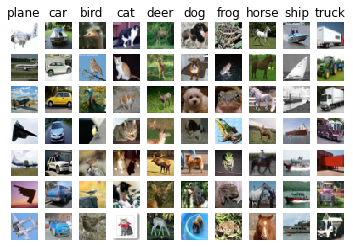

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


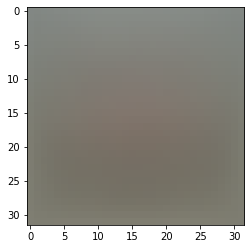

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **deep_learning_su/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from deep_learning_su.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.382081


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from deep_learning_su.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -31.872350 analytic: -31.872350, relative error: 3.758889e-12
numerical: 13.185495 analytic: 13.185495, relative error: 1.744307e-11
numerical: -3.432122 analytic: -3.432122, relative error: 1.136839e-10
numerical: -4.218008 analytic: -4.218008, relative error: 1.244153e-11
numerical: 21.352845 analytic: 21.352845, relative error: 3.385942e-12
numerical: -4.355142 analytic: -4.355142, relative error: 3.051818e-11
numerical: -4.013580 analytic: -4.013580, relative error: 1.168881e-10
numerical: 28.106820 analytic: 28.106820, relative error: 7.618026e-12
numerical: -22.199210 analytic: -22.199210, relative error: 1.188705e-11
numerical: 23.848051 analytic: 23.848051, relative error: 5.576056e-13
numerical: -2.650077 analytic: -2.650077, relative error: 5.328204e-11
numerical: 20.485547 analytic: 20.485547, relative error: 1.346388e-12
numerical: 19.391626 analytic: 19.391626, relative error: 4.449039e-12
numerical: 12.790468 analytic: 12.790468, relative error: 5.732256e-12
nu

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from deep_learning_su.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.382081e+00 computed in 0.095674s
Vectorized loss: 8.382081e+00 computed in 0.003017s
difference: 0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.101763s
Vectorized loss and gradient: computed in 0.002936s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from deep_learning_su.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 399.078122
iteration 100 / 1500: loss 236.602737
iteration 200 / 1500: loss 145.728421
iteration 300 / 1500: loss 87.722455
iteration 400 / 1500: loss 55.981307
iteration 500 / 1500: loss 35.425608
iteration 600 / 1500: loss 23.396014
iteration 700 / 1500: loss 16.206796
iteration 800 / 1500: loss 11.990705
iteration 900 / 1500: loss 8.856076
iteration 1000 / 1500: loss 7.726283
iteration 1100 / 1500: loss 6.038130
iteration 1200 / 1500: loss 5.961532
iteration 1300 / 1500: loss 5.906000
iteration 1400 / 1500: loss 5.375476
That took 7.212912s


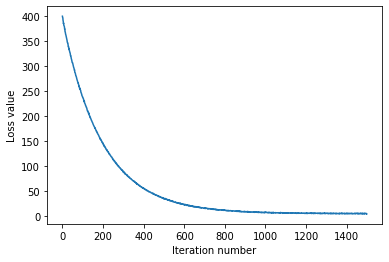

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.381980
validation accuracy: 0.387000


In [19]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
best_lr = 1e-7
best_reg = 2.5e4
for learning_rate in np.linspace(learning_rates[0], learning_rates[1], num=8):
    for reg in np.linspace(regularization_strengths[0], regularization_strengths[1], num=8):
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate, reg, num_iters=1500,
                              verbose=True)

        y_train_pred = svm.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[learning_rate, reg] = training_accuracy, validation_accuracy

        if(validation_accuracy > best_val):
            best_val = validation_accuracy
            best_svm = svm
            best_lr = learning_rate
            best_reg = reg
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
print(best_lr, best_reg)

iteration 0 / 1500: loss 405.700479
iteration 100 / 1500: loss 241.073431
iteration 200 / 1500: loss 147.525659
iteration 300 / 1500: loss 90.027473
iteration 400 / 1500: loss 57.081375
iteration 500 / 1500: loss 36.607909
iteration 600 / 1500: loss 24.565923
iteration 700 / 1500: loss 16.032721
iteration 800 / 1500: loss 11.560472
iteration 900 / 1500: loss 9.197223
iteration 1000 / 1500: loss 7.713228
iteration 1100 / 1500: loss 6.189809
iteration 1200 / 1500: loss 6.434892
iteration 1300 / 1500: loss 5.703002
iteration 1400 / 1500: loss 5.179144
iteration 0 / 1500: loss 460.694042
iteration 100 / 1500: loss 254.799625
iteration 200 / 1500: loss 145.005029
iteration 300 / 1500: loss 83.323545
iteration 400 / 1500: loss 48.599691
iteration 500 / 1500: loss 29.755742
iteration 600 / 1500: loss 18.536841
iteration 700 / 1500: loss 12.737407
iteration 800 / 1500: loss 8.941390
iteration 900 / 1500: loss 7.080104
iteration 1000 / 1500: loss 5.918800
iteration 1100 / 1500: loss 5.241217
it

iteration 1200 / 1500: loss 35.956704
iteration 1300 / 1500: loss 41.814005
iteration 1400 / 1500: loss 31.099792
iteration 0 / 1500: loss 780.318354
iteration 100 / 1500: loss 27.841127
iteration 200 / 1500: loss 44.086351
iteration 300 / 1500: loss 26.141188
iteration 400 / 1500: loss 36.183155
iteration 500 / 1500: loss 28.225834
iteration 600 / 1500: loss 31.812053
iteration 700 / 1500: loss 31.869458
iteration 800 / 1500: loss 37.926155
iteration 900 / 1500: loss 19.724467
iteration 1000 / 1500: loss 32.200016
iteration 1100 / 1500: loss 33.805900
iteration 1200 / 1500: loss 30.183926
iteration 1300 / 1500: loss 37.301867
iteration 1400 / 1500: loss 43.805393
iteration 0 / 1500: loss 408.634115
iteration 100 / 1500: loss 68.633102
iteration 200 / 1500: loss 68.830388
iteration 300 / 1500: loss 43.139983
iteration 400 / 1500: loss 48.882676
iteration 500 / 1500: loss 95.152385
iteration 600 / 1500: loss 53.678132
iteration 700 / 1500: loss 33.205179
iteration 800 / 1500: loss 60.98

iteration 500 / 1500: loss 285.376610
iteration 600 / 1500: loss 261.418582
iteration 700 / 1500: loss 207.665281
iteration 800 / 1500: loss 178.784549
iteration 900 / 1500: loss 230.932983
iteration 1000 / 1500: loss 177.212484
iteration 1100 / 1500: loss 188.228530
iteration 1200 / 1500: loss 259.882358
iteration 1300 / 1500: loss 285.403401
iteration 1400 / 1500: loss 236.824973
iteration 0 / 1500: loss 731.177653
iteration 100 / 1500: loss 275.177286
iteration 200 / 1500: loss 244.533109
iteration 300 / 1500: loss 220.618909
iteration 400 / 1500: loss 277.193821
iteration 500 / 1500: loss 239.533782
iteration 600 / 1500: loss 189.999385
iteration 700 / 1500: loss 204.987332
iteration 800 / 1500: loss 273.436961
iteration 900 / 1500: loss 267.260769
iteration 1000 / 1500: loss 327.511001
iteration 1100 / 1500: loss 241.786768
iteration 1200 / 1500: loss 197.110959
iteration 1300 / 1500: loss 273.261168
iteration 1400 / 1500: loss 278.301357
iteration 0 / 1500: loss 789.180417
iterat

iteration 1000 / 1500: loss 857.952712
iteration 1100 / 1500: loss 600.598477
iteration 1200 / 1500: loss 797.483410
iteration 1300 / 1500: loss 837.303168
iteration 1400 / 1500: loss 918.472672
iteration 0 / 1500: loss 630.487545
iteration 100 / 1500: loss 1202.689125
iteration 200 / 1500: loss 1005.275380
iteration 300 / 1500: loss 1054.172389
iteration 400 / 1500: loss 946.026966
iteration 500 / 1500: loss 1045.575110
iteration 600 / 1500: loss 1070.123843
iteration 700 / 1500: loss 1173.051351
iteration 800 / 1500: loss 1084.749807
iteration 900 / 1500: loss 1010.934374
iteration 1000 / 1500: loss 991.076765
iteration 1100 / 1500: loss 980.740012
iteration 1200 / 1500: loss 981.223836
iteration 1300 / 1500: loss 954.324033
iteration 1400 / 1500: loss 973.424851
iteration 0 / 1500: loss 669.342722
iteration 100 / 1500: loss 1676.737536
iteration 200 / 1500: loss 1786.851971
iteration 300 / 1500: loss 1827.110938
iteration 400 / 1500: loss 1739.962048
iteration 500 / 1500: loss 1681.

iteration 1400 / 1500: loss 202580066362526861694526525762510471626224235191113718403715128702330305284300482199811204931267683750367511555419368335873935389674503756905926953165199197094952304640.000000
iteration 0 / 1500: loss 413.096286
iteration 100 / 1500: loss 986.135069
iteration 200 / 1500: loss 818.464753
iteration 300 / 1500: loss 872.252724
iteration 400 / 1500: loss 992.342992
iteration 500 / 1500: loss 746.935086
iteration 600 / 1500: loss 919.259073
iteration 700 / 1500: loss 958.328244
iteration 800 / 1500: loss 960.868627
iteration 900 / 1500: loss 965.324485
iteration 1000 / 1500: loss 1049.578812
iteration 1100 / 1500: loss 1209.467422
iteration 1200 / 1500: loss 908.131958
iteration 1300 / 1500: loss 852.902447
iteration 1400 / 1500: loss 1126.200965
iteration 0 / 1500: loss 461.084281
iteration 100 / 1500: loss 1715.064645
iteration 200 / 1500: loss 1574.575085
iteration 300 / 1500: loss 1747.122168
iteration 400 / 1500: loss 1647.883104
iteration 500 / 1500: loss 1

/home/tony/vscode-repo/deep-learning/assignment1/deep_learning_su/classifiers/linear_svm.py:88: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W) / 2
/home/tony/vscode-repo/deep-learning/assignment1/.env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/tony/vscode-repo/deep-learning/assignment1/deep_learning_su/classifiers/linear_svm.py:88: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W) / 2


iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 779.626734
iteration 100 / 1500: loss 362391576938003101205414776644772560896.000000
iteration 200 / 1500: loss 59900425302277159245280374073587358716442185495109116424303729691152351232.000000
iteration 300 / 1500: loss 9901060564681725701485464045465701614431730602546809661319687063710779550183011470988641035698509822776311808.000000
iteration 400 / 1500: loss 1636566014528262642981825929521642616840523217955384834753294719280748093381415870581377890653586568868241865534800072937420454916037687380017152.000000
iteration 500 / 1500: loss 270511255073311217521658376249094442809073632625850972587334530558298790092785498343012131940847401668623699390436376172480525003519415868061685617185689859523409664086064609886208.000000
iteration 600 / 1500: loss 4471334396029909155473073332796238328863595241063260565267721241136423519558200532859026625907275227810382841016507735984603879840039414150677153613993

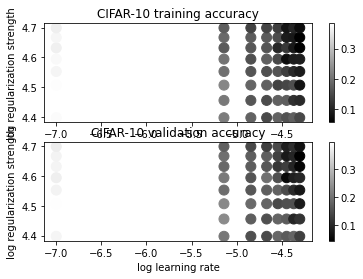

In [20]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [21]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.377000


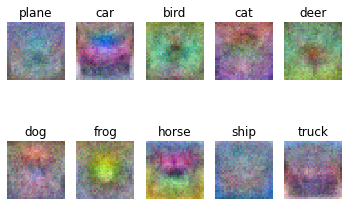

In [22]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** As a line (or column, depends) in W matches a class, and the similarity between images is measured by how similar are their pixels, then when the model is trained well, that line class in W looks like an image of the class. Actually it has elements of many images if there is a variaty of images in its class. 